In [12]:
import pandas as pd
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
import numpy as np
from hyperopt import Trials, tpe, fmin


In [51]:
ma = pd.read_csv("../16 Mycoplosma/Mycoplasma agalactiae.csv")
map = pd.read_csv("../16 Mycoplosma/Mycoplasma agalactiae PG2.csv")
marth = pd.read_csv("../16 Mycoplosma/Mycoplasma arthritidis 158L3-1.csv")
mcap = pd.read_csv("../16 Mycoplosma/Mycoplasma capricolum subsp. capricolum ATCC 27343.csv")
mcon = pd.read_csv("../16 Mycoplosma/Mycoplasma conjunctivae HRC581.csv")
mcro = pd.read_csv("../16 Mycoplosma/Mycoplasma crocodyli MP145.csv")
mgal = pd.read_csv("../16 Mycoplosma/Mycoplasma gallisepticum str. R(low).csv")
mhom = pd.read_csv("../16 Mycoplosma/Mycoplasma hominis.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/Mycoplasma hyopneumoniae J.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/Mycoplasma hyopneumoniae 232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/Mycoplasma hyopneumoniae 7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/Mycoplasma mobile 163K.csv")
mms = pd.read_csv("../16 Mycoplosma/Mycoplasma mycoides subsp. mycoides SC str. PG1.csv")
mpHF = pd.read_csv("../16 Mycoplosma/Mycoplasma penetrans HF-2.csv")
mpM = pd.read_csv("../16 Mycoplosma/Mycoplasma pneumoniae M129.csv")
ms53 = pd.read_csv("../16 Mycoplosma/Mycoplasma synoviae 53.csv")

In [2]:
ma = pd.read_csv("../16 Mycoplosma/ma.csv")
map = pd.read_csv("../16 Mycoplosma/map.csv")
marth = pd.read_csv("../16 Mycoplosma/marth.csv")
mcap = pd.read_csv("../16 Mycoplosma/mcap.csv")
mcon = pd.read_csv("../16 Mycoplosma/mcon.csv")
mcro = pd.read_csv("../16 Mycoplosma/mcro.csv")
mgal = pd.read_csv("../16 Mycoplosma/mgal.csv")
mhom = pd.read_csv("../16 Mycoplosma/mhom.csv")
mhyoJ = pd.read_csv("../16 Mycoplosma/mhyoJ.csv")
mhyo232 = pd.read_csv("../16 Mycoplosma/mhyo232.csv")
mhyo7448 = pd.read_csv("../16 Mycoplosma/mhyo7448.csv")
mm163K = pd.read_csv("../16 Mycoplosma/mm163K.csv")
mms = pd.read_csv("../16 Mycoplosma/mms.csv")
mpHF = pd.read_csv("../16 Mycoplosma/mpHF.csv")
mpM = pd.read_csv("../16 Mycoplosma/mpM.csv")
ms53 = pd.read_csv("../16 Mycoplosma/ms53.csv")

In [67]:
#add features entropy
new_features = pd.read_csv("../16 Mycoplosma/GENE - Copy.csv")
dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
new_features = new_features[new_features['name'].isin(ms53['name'])]
ms53 = pd.merge(ms53,new_features[['name','nSE2','nSE3','nGE2','nGE3']], on='name', how='left')
ms53.to_csv("../16 Mycoplosma/ms53.csv")

In [50]:
def generate_train_test_dataset(index):
    dataset_names = [ma, map, marth, mcap, mcon, mcro, mgal, mhom, mhyoJ, mhyo232, mhyo7448, mm163K, mms, mpHF, mpM, ms53]
    merged_train = dataset_names[:index]+dataset_names[index+1:]
    train_data = pd.concat(merged_train)
    test_data = dataset_names[index]
    return train_data,test_data

In [4]:
train_data , test_data = generate_train_test_dataset(0)

In [5]:
def handle_dataset(dataset):
    columns_to_drop = ['identity','name', 'Amino acid', 'protein_sequence', 'essentiality']
    Xs = dataset.drop(columns = columns_to_drop)
    y = dataset['essentiality']
    return Xs,y

In [6]:
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)

In [17]:
def rf_bca_cv(params):
    params = {
    'n_estimators': int(params['n_estimators']), 
    'max_depth': int(params['max_depth']), 
    'min_samples_split': params['min_samples_split'],
    'min_samples_leaf': params['min_samples_leaf']
}
    scorer = make_scorer(balanced_accuracy_score)
    model = RandomForestClassifier(random_state=42, **params)
    score = -cross_val_score(model, X_resampled, y_resampled, cv=5,scoring=scorer, ).mean()
    return score

In [13]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 700, 1),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
}

In [14]:

trials = Trials()

best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )


100%|██████████| 50/50 [03:02<00:00,  3.66s/trial, best loss: -0.5]


In [15]:
model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])
model.fit(Xs_train,y_train)
tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))

print("Best BCA {:.3f} params {}".format( rf_bca_cv(best), best))

Best BCA -0.500 params {'max_depth': 14.0, 'min_samples_leaf': 0.4535706501890462, 'min_samples_split': 0.6581070979089769, 'n_estimators': 579.0}


In [16]:
print(tpe_test_score)

0.5


In [19]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)

In [20]:
trials = Trials()

best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )


100%|██████████| 50/50 [02:37<00:00,  3.15s/trial, best loss: -0.8148784478728377]


In [21]:
model_resampled = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),
                               max_depth=int(best['max_depth']), min_samples_split=best['min_samples_split'],
                               min_samples_leaf=best['min_samples_leaf'])
model_resampled.fit(X_resampled, y_resampled)
tpe_test_score = balanced_accuracy_score(y_test, model_resampled.predict(Xs_test))

print("Best BCA {:.3f} params {}".format(rf_bca_cv(best), best))
print(tpe_test_score)

Best BCA -0.815 params {'max_depth': 18.0, 'min_samples_leaf': 0.10030016223764829, 'min_samples_split': 0.2591505195174929, 'n_estimators': 690.0}
0.8201301891427167


ValueError: x and y must have same first dimension, but have shapes (17,) and (21,)

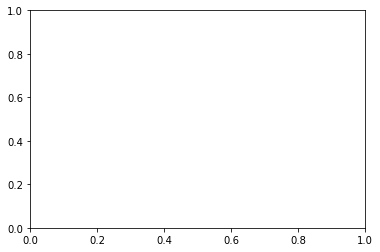

In [24]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#feature selection
#RFE
score = []
scorer = make_scorer(balanced_accuracy_score)
for i in range(26,5,-1):
	X_mutual = SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(X_resampled, y_resampled)
	once = cross_val_score(model_resampled, X_mutual, y_resampled, cv=10,scoring=scorer)
	score.append(once.mean())


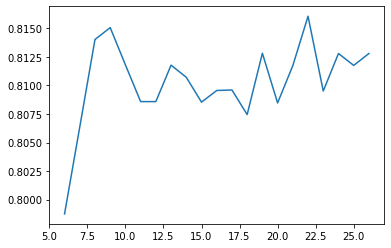

In [25]:
plt.plot(range(26,5,-1), score)
plt.show()    

In [26]:
from sklearn.feature_selection import RFECV

X_mutual = SelectKBest(score_func=mutual_info_classif, k=23).fit_transform(X_resampled, y_resampled)
rfecv = RFECV(estimator=model_resampled,  
              min_features_to_select=5, 
              step=1,               
              cv=5,
              verbose = 1,
              n_jobs = 1
              ).fit(X_mutual,y_resampled)
X_RFECV = rfecv.transform(X_mutual)
print("RFECVresult——————————————————————————————————————————————————")
print("valid : %d" % rfecv.n_features_)
print("ranking : %s" % list(rfecv.ranking_))

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 featur

In [28]:
all_feature_names = ["GC_Content","CAI","A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","nSE2","nSE3","nGE2","nGE3"]
selected_feature_names = [all_feature_names[i] for i, rank in enumerate(rfecv.ranking_) if rank == 1]

print("Selected feature names:", selected_feature_names)

Selected feature names: ['GC_Content', 'A', 'R', 'G', 'H', 'W', 'Y', 'V', 'SE2']


In [29]:
Wrapper_score = cross_val_score(model_resampled,X_RFECV,y_resampled,cv=5,scoring=scorer).mean()
print(Wrapper_score)

0.8148901355773726


In [35]:
model_resampled.fit(X_resampled,y_resampled)
Xs_test_mutual = SelectKBest(mutual_info_classif, k=23).fit_transform(Xs_test,y_test)
Xs_test_rfe = rfecv.transform(Xs_test_mutual)
test_score = balanced_accuracy_score(y_test, model_resampled.predict(Xs_test))

In [65]:
def feature_selection(Xs,y):
    Xs_result = SelectKBest(mutual_info_classif, k=23).fit_transform(Xs,y)
    Xs_result = rfecv.transform(Xs_result)
    return Xs_result

In [ ]:
models= []
score = 0
scores = []

for i in range(12,15):
    if i == 3 :
        scores.append(0.5127968346578312)
        continue
    if i ==12:
        scores.append(0.5123582987129056)
        continue
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    X_resampled = feature_selection(X_resampled,y_resampled)
    trials = Trials()
    best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])
    models.append(model)
    model.fit(X_resampled,y_resampled)
    Xs_test_fs = feature_selection(Xs_test,y_test)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test_fs))
    scores.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model = model

In [96]:
scores = [0.501412429378531, 0.5011037527593819, 0.5502897350993378, 0.5127968346578312, 0.501628664495114, 0.5015243902439024, 0.5012820512820513, 0.5189003436426117, 0.5015151515151515, 0.5007598784194529, 0.5015151515151515, 0.501466275659824,0.5123582987129056, 0.5012820512820513, 0.4975609756097561]

In [97]:
train_data, test_data = generate_train_test_dataset(2)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
X_resampled = feature_selection(X_resampled,y_resampled)
trials = Trials()
best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
          )
best_model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])

100%|██████████| 50/50 [01:48<00:00,  2.16s/trial, best loss: -0.8125943719972547]


In [103]:
train_data, test_data = generate_train_test_dataset(2)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
X_resampled = feature_selection(X_resampled,y_resampled)
best_model.fit(X_resampled,y_resampled)

RandomForestClassifier(max_depth=5, min_samples_leaf=0.12017969486189678,
                       min_samples_split=0.2104010981317534, n_estimators=404,
                       random_state=42)

In [99]:
models_nfs= []
score = 0
scores_nfs = []
for i in range(0,15):
    train_data, test_data = generate_train_test_dataset(i)
    Xs_train,y_train = handle_dataset(train_data)
    Xs_test,y_test = handle_dataset(test_data)
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
    trials = Trials()
    best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
    )
    model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])
    models_nfs.append(model)
    model.fit(X_resampled,y_resampled)
    tpe_test_score=balanced_accuracy_score(y_test, model.predict(Xs_test))
    scores_nfs.append(tpe_test_score)
    print(tpe_test_score)
    if score < tpe_test_score:
        score = tpe_test_score
        best_model_nfs = model

100%|██████████| 50/50 [02:34<00:00,  3.10s/trial, best loss: -0.8148784478728377]
0.8201301891427167
100%|██████████| 50/50 [02:02<00:00,  2.46s/trial, best loss: -0.8065934065934066]
0.7593818984547461
100%|██████████| 50/50 [01:46<00:00,  2.13s/trial, best loss: -0.8125829329672843]
0.6254139072847682
100%|██████████| 50/50 [02:25<00:00,  2.91s/trial, best loss: -0.8072487113402061]
0.4835390946502058
100%|██████████| 50/50 [02:25<00:00,  2.90s/trial, best loss: -0.8069091741020362]
0.7308417623864221
100%|██████████| 50/50 [01:59<00:00,  2.39s/trial, best loss: -0.8041447682752031]
0.7671200750469043
100%|██████████| 50/50 [02:13<00:00,  2.68s/trial, best loss: -0.7963768115942029]
0.7566332218506131
100%|██████████| 50/50 [02:34<00:00,  3.10s/trial, best loss: -0.8122397620681765]
0.7545668294447458
100%|██████████| 50/50 [02:06<00:00,  2.53s/trial, best loss: -0.7976664378860672]
0.7363636363636363
100%|██████████| 50/50 [01:50<00:00,  2.21s/trial, best loss: -0.7865567765567765]

In [104]:
from joblib import dump

dump(best_model, '../../model/RF_FS_model.joblib')

['../../model/RF_FS_model.joblib']

In [102]:
print(scores_nfs)
#[0.8201301891427167, 0.7593818984547461, 0.6254139072847682, 0.4835390946502058, 0.7308417623864221, 0.7671200750469043, 0.7566332218506131, 0.7545668294447458, 0.7363636363636363, 0.8050299048926366, 0.7946969696969697, 0.6348973607038123, 0.6936868686868687, 0.7435897435897436, 0.6010886994683096]

[0.8201301891427167, 0.7593818984547461, 0.6254139072847682, 0.4835390946502058, 0.7308417623864221, 0.7671200750469043, 0.7566332218506131, 0.7545668294447458, 0.7363636363636363, 0.8050299048926366, 0.7946969696969697, 0.6348973607038123, 0.6936868686868687, 0.7435897435897436, 0.6010886994683096]


In [105]:
train_data, test_data = generate_train_test_dataset(0)
Xs_train,y_train = handle_dataset(train_data)
Xs_test,y_test = handle_dataset(test_data)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(Xs_train, y_train)
trials = Trials()
best=fmin(fn=rf_bca_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=50, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
          )
best_model = RandomForestClassifier(random_state=42, n_estimators=int(best['n_estimators']),max_depth=int(best['max_depth']),min_samples_split=best['min_samples_split'],min_samples_leaf=best['min_samples_leaf'])
best_model.fit(X_resampled,y_resampled)

100%|██████████| 50/50 [02:35<00:00,  3.12s/trial, best loss: -0.8148784478728377]


RandomForestClassifier(max_depth=18, min_samples_leaf=0.10030016223764829,
                       min_samples_split=0.2591505195174929, n_estimators=690,
                       random_state=42)

In [106]:
dump(best_model, '../../model/RF_model.joblib')

['../../model/RF_model.joblib']